In [24]:
import re

import unicodedata
import nltk
from wordcloud import WordCloud
from nltk import ngrams
import nltk.sentiment

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import prepare as p
import acquire as a

from env import get_connection
from requests import get
import requests
from bs4 import BeautifulSoup

In [2]:
url = get_connection('spam_db')

In [3]:
query = '''
        SELECT *
        FROM spam
        '''

# 1. Spam Data
a. Load the spam data set.

In [4]:
# read sql
df = pd.read_sql(query, url, index_col = 'id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
ham_words= p.clean(' '.join(df[df.label == 'ham']['text']))
spam_words = p.clean(' '.join(df[df.label == 'spam']['text']))
all_words = p.clean(' '.join(df['text']))
                   

In [6]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()


In [7]:
# lets combine all 3 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['ham', 'spam', 'all']

word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
ltgt,276,0,276
go,273,31,304
ok,272,5,277


In [8]:
def make_ngrams(words, n):
    return pd.Series(nltk.ngrams(words, n)).value_counts().head(20)


b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

c. Is there any overlap in the bigrams for the spam data and the ham data?



In [9]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

/var/folders/fj/k2vb8khs0gz6fm0_xh02d41c0000gn/T/ipykernel_76497/2462859176.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<Axes: >

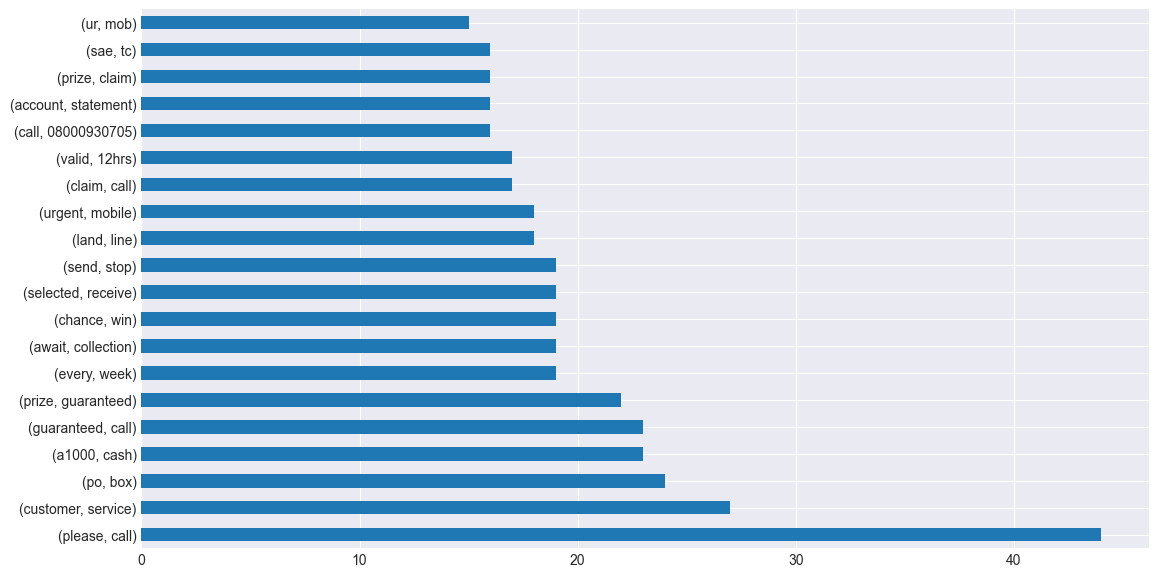

In [10]:
pd.Series(nltk.bigrams(spam_words)).value_counts().head(20).plot.barh()


In [11]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
Name: count, dtype: int64

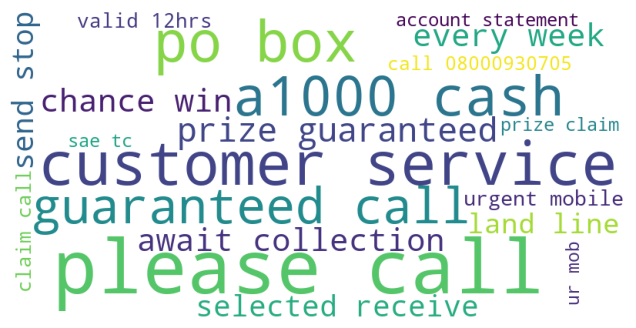

In [12]:

data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
def plot_bigrams(words):
    word_data = {k[0] + ' ' + k[1]: v for k, v in words.to_dict().items()}
    
    word_img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_data)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(word_img)
    plt.axis('off')
    plt.show()

<Axes: >

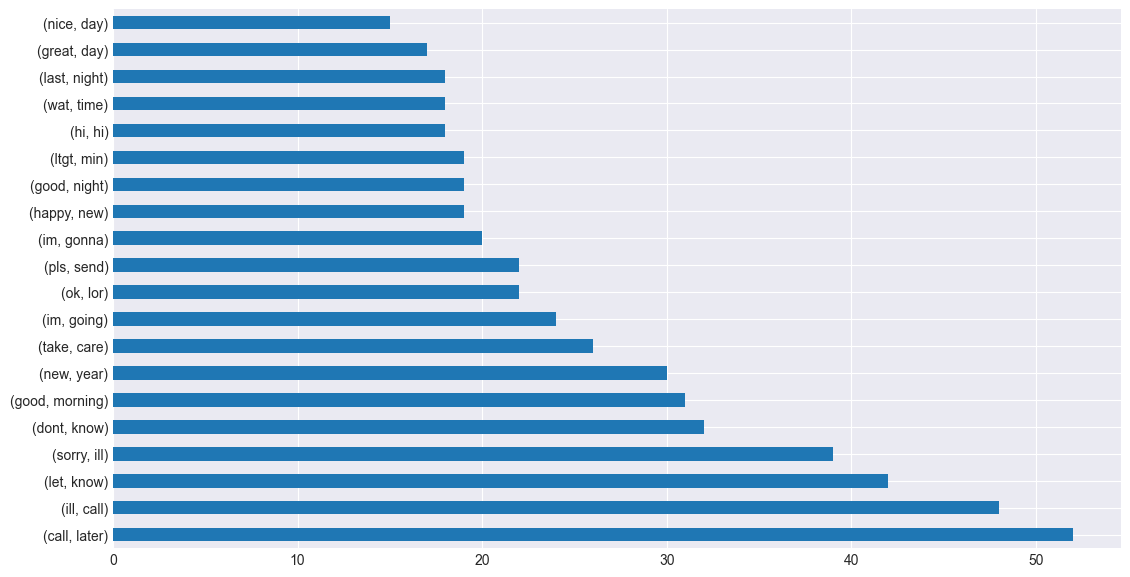

In [14]:
pd.Series(nltk.bigrams(ham_words)).value_counts().head(20).plot.barh()


In [15]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
Name: count, dtype: int64

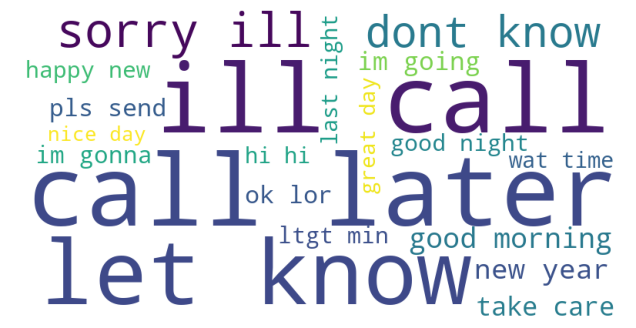

In [16]:
plot_bigrams(top_20_ham_bigrams)


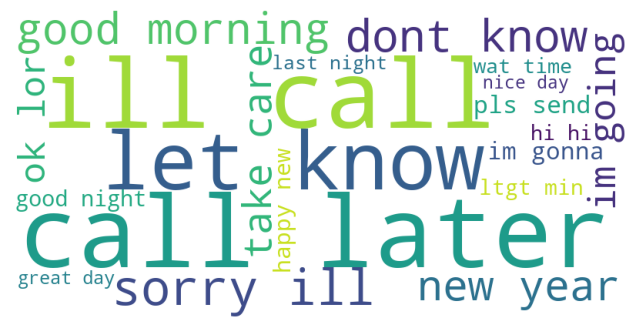

In [17]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


OVERLAP

In [18]:
overlap_list = [bigram for bigram in top_20_spam_bigrams.keys() if bigram in top_20_ham_bigrams.keys()]
overlap_list

[]

 d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.


In [19]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(reply, call, 08000930705)    14
(land, line, claim)           14
(private, 2003, account)      13
Name: count, dtype: int64

<Axes: >

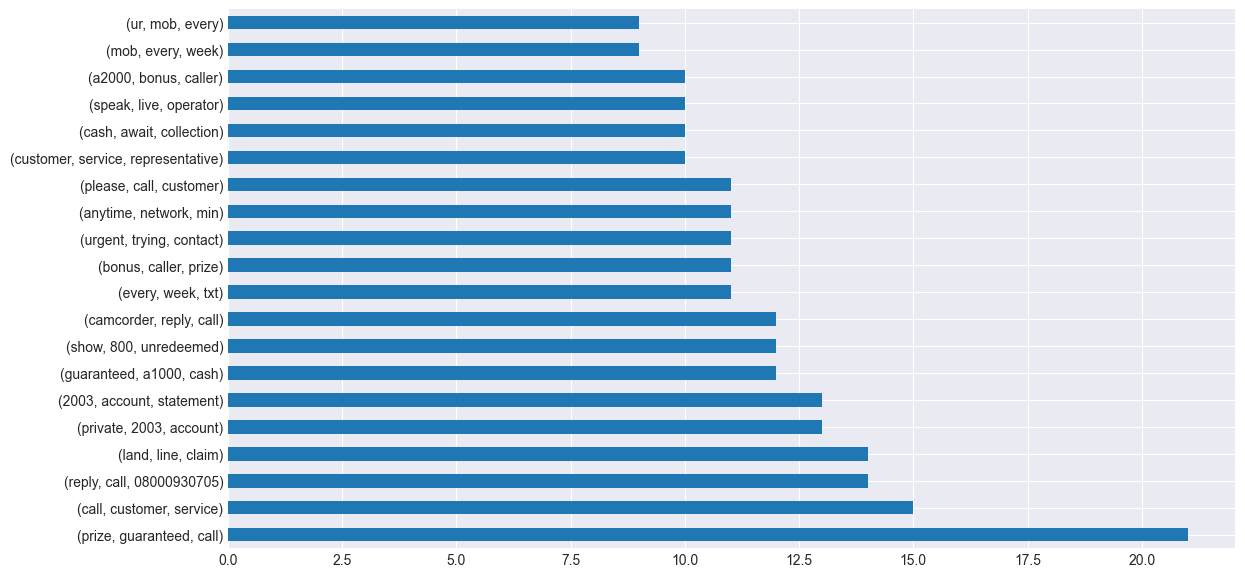

In [20]:
pd.Series(nltk.ngrams(spam_words, 3)).value_counts().head(20).plot.barh()


In [21]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
Name: count, dtype: int64

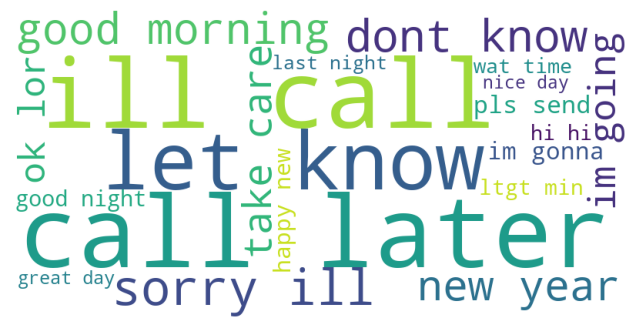

In [22]:
spam_trigram_data = {k[0]+ ' '+k[1]+ ' '+k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
spam_tirgram_img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(spam_trigram_data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

<Axes: >

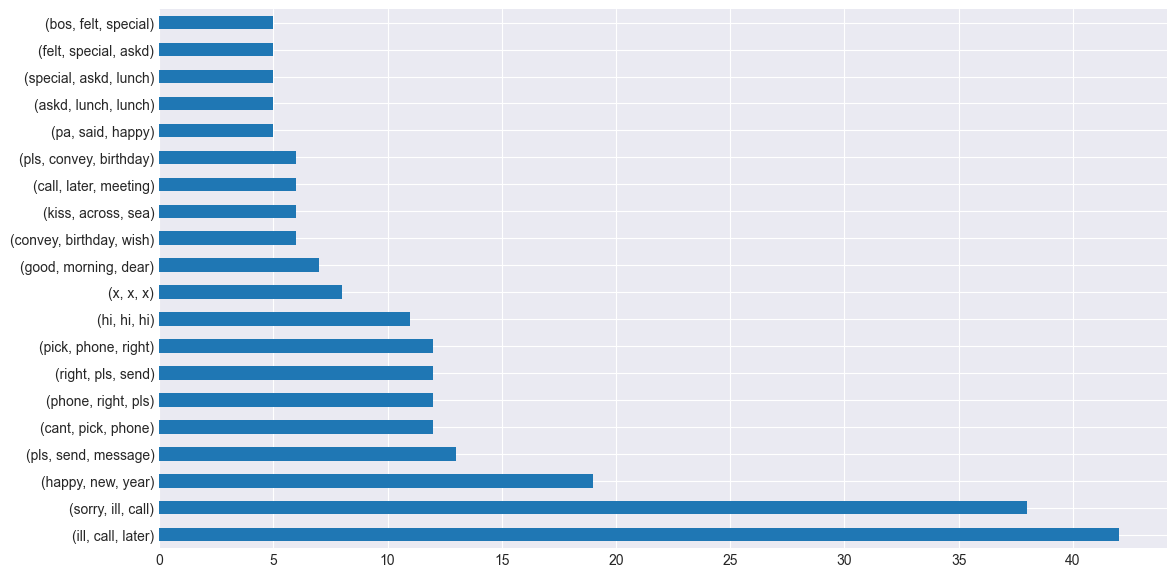

In [23]:
pd.Series(nltk.ngrams(ham_words, 3)).value_counts().head(20).plot.barh()


# 2. Explore the blog articles using the techniques discussed in the exploration lesson.



In [25]:
a.acquire_info()

get_blog_articles2()
scrape_one_page(topic)
get_news_articles(topic_list)


In [26]:
p.prepare_info()

basic_clean(original)
tokenize(basic_cleaned)
remove_stopwords(lemma_or_stem)
stem(clean_tokenize)
lemmatize(clean_tokenize)


In [29]:
def get_all_articles(url):
    article_list = []
    headers = {"User-Agent": "Chrome/91.0.4472.124"}

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract the href attribute from <a> tags with class 'more-link'
    links = soup.find_all('a', class_='more-link')
    link_list = [link['href'] for link in links]

    for link in link_list:
        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')

        title = soup.find('h1', class_='entry-title').text
        divcont = soup.find('div', class_='entry-content')
        article = [para.text for para in divcont.find_all('p')]

        article_nl = ' '.join(article)

        article_dict = {'title': title, 'content': article_nl}
        article_list.append(article_dict)

    codeup_df = pd.DataFrame(article_list)

    return codeup_df

In [30]:
blogs = get_all_articles('https://codeup.com/blog/')


In [32]:
blogs

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Codeup is hosting a Women in Tech Panel in hon...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Codeup is hosting a Women in Tech Panel in hon...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Codeup is hosting a Women in Tech Panel in hon...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Codeup is hosting a Women in Tech Panel in hon...
5,Black Excellence in Tech: Panelist Spotlight –...,Codeup is hosting a Black Excellence in Tech ...


In [34]:
blogs['clean_norm_token'] = blogs.content.apply(p.basic_clean).apply(p.tokenize).apply(p.remove_stopwords)


In [35]:
blogs['lemmatized'] = blogs.clean_norm_token.apply(p.lemmatize)


In [36]:
blogs


,title,content,clean_norm_token,lemmatized
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...,may traditionally known asian american pacific...,may traditionally known asian american pacific...
1,Women in tech: Panelist Spotlight – Magdalena ...,Codeup is hosting a Women in Tech Panel in hon...,codeup hosting women tech panel honor womens h...,codeup hosting woman tech panel honor woman hi...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Codeup is hosting a Women in Tech Panel in hon...,codeup hosting women tech panel honor womens h...,codeup hosting woman tech panel honor woman hi...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Codeup is hosting a Women in Tech Panel in hon...,codeup hosting women tech panel honor womens h...,codeup hosting woman tech panel honor woman hi...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Codeup is hosting a Women in Tech Panel in hon...,codeup hosting women tech panel honor womens h...,codeup hosting woman tech panel honor woman hi...
5,Black Excellence in Tech: Panelist Spotlight –...,Codeup is hosting a Black Excellence in Tech ...,codeup hosting black excellence tech panel hon...,codeup hosting black excellence tech panel hon...


In [38]:
blog_words = p.clean(' '.join(blogs['lemmatized']))


In [39]:
blog_freq = pd.Series(blog_words).value_counts()


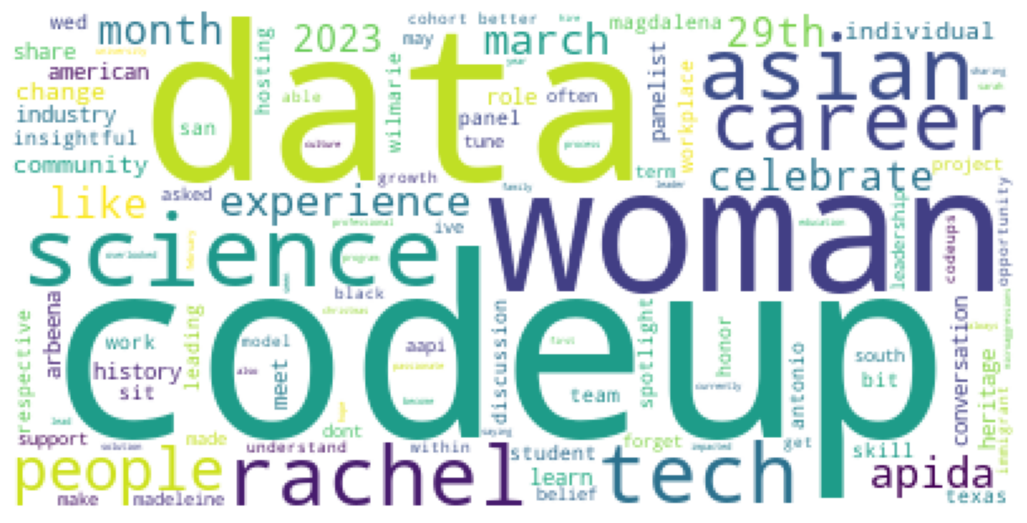

In [40]:
blog_img = WordCloud(background_color='white').generate_from_frequencies(blog_freq)
plt.imshow(blog_img)
plt.axis('off')
plt.show()

<Axes: >

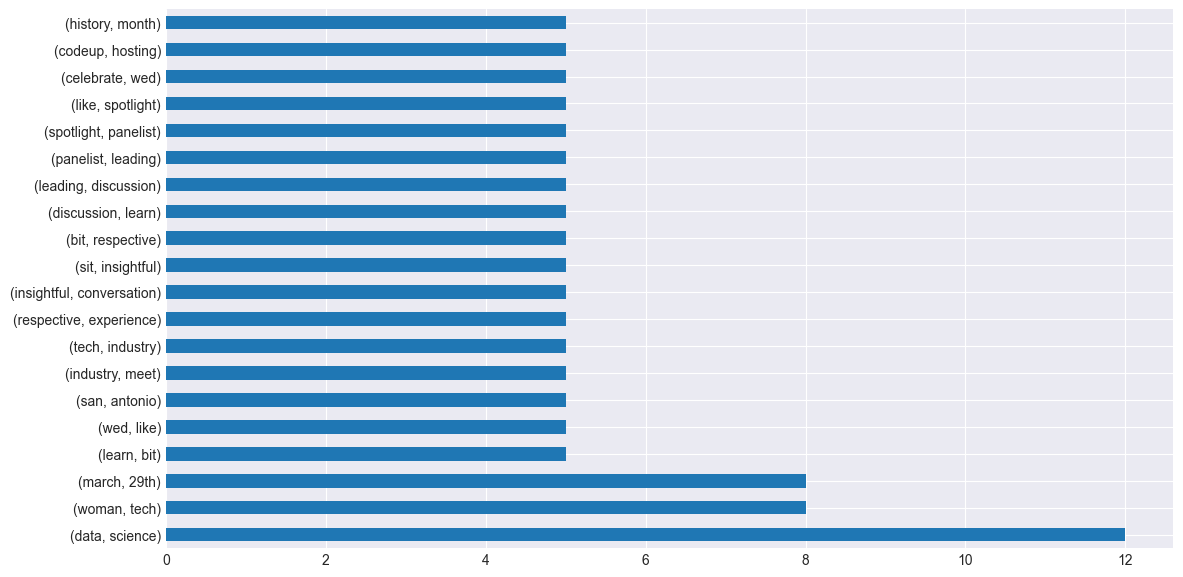

In [41]:
pd.Series(nltk.bigrams(blog_words)).value_counts().head(20).plot.barh()


In [42]:
top_20_blog_bigrams = (pd.Series(nltk.ngrams(blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_blog_bigrams.head()

(data, science)    12
(woman, tech)       8
(march, 29th)       8
(learn, bit)        5
(wed, like)         5
Name: count, dtype: int64

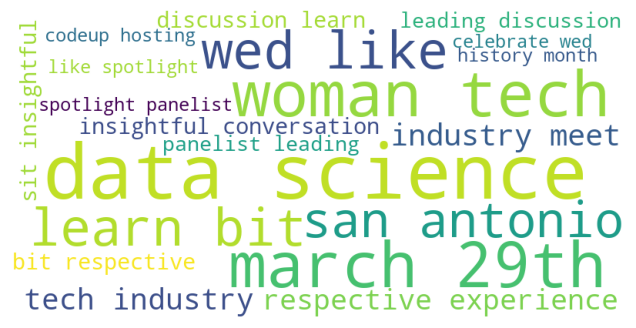

In [43]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_blog_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [44]:
top_20_blog_trigram = make_ngrams(blog_words, 3)
top_20_blog_trigram

(leading, discussion, learn)       5
(tech, panel, honor)               5
(bit, respective, experience)      5
(learn, bit, respective)           5
(discussion, learn, bit)           5
(tech, industry, meet)             5
(panelist, leading, discussion)    5
(spotlight, panelist, leading)     5
(like, spotlight, panelist)        5
(wed, like, spotlight)             5
(celebrate, wed, like)             5
(2023, celebrate, wed)             5
(sit, insightful, conversation)    5
(woman, tech, panel)               4
(hosting, woman, tech)             4
(codeup, hosting, woman)           4
(panel, honor, woman)              4
(woman, tech, industry)            4
(experience, woman, tech)          4
(respective, experience, woman)    4
Name: count, dtype: int64

# 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.